## Testing the Model on VGG Data

### Preprocessing the test dataset:

**The below function has been imported to preprocess the VGG Data:**

In [ ]:
import torchvision.datasets as datasets
import os
import numpy as np
import random
class VGGTestDataset(datasets.ImageFolder):
    def __init__(self, dir, transform=None):
        super(VGGTestDataset, self).__init__(dir, transform)
        self.dir = dir
        self.test_images = self.get_pairs_paths()
    def get_tuple(self, person1, photo_name1, person2, photo_name2):
      return os.path.join(self.dir, person1, photo_name1), \
                os.path.join(self.dir, person2, photo_name2), \
                person1 == person2
    def get_pairs_paths(self):
        pairs = []
        persons = os.listdir(self.dir)
        for person in persons:
          photos = os.listdir(os.path.join(self.dir, person))
          # get positive samples (max 100 combinations per folder)
          candidates = [(a, b) for idx, a in enumerate(photos) for b in photos[idx + 1:]]
          pos_samples = [self.get_tuple(person, a, person, b) for a, b in candidates[:100]]
          pairs.extend(pos_samples)
          neg_samples = 0
          while(neg_samples < len(pos_samples)):
            for photo in photos:
              new_person = random.choice(persons)
              pairs.append(self.get_tuple(person, photo, new_person, random.choice(os.listdir(os.path.join(self.dir, new_person)))))
              neg_samples += 1
              if neg_samples >= len(pos_samples):
                break
        return pairs
    def __getitem__(self, index):
        def transform(img_path):
            """Convert image into numpy array and apply transformation
               Doing this so that it is consistent with all other datasets
               to return a PIL Image.
            """
            img = self.loader(img_path)
            return self.transform(img)
        (path_1, path_2, issame) = self.test_images[index]
        img1, img2 = transform(path_1), transform(path_2)
        return img1, img2, issame
    def __len__(self):
        return len(self.test_images)



**The below function is used to normalize the test data and load it for evaluation.**

In [ ]:
def load_data_for_testing(image_size, batch_size, num_workers):
    data_transforms = transforms.Compose([
    transforms.Resize(size=(160,160)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.6025, 0.4704, 0.4078],
        std=[0.2493, 0.2278, 0.2257]
    )
    ])
    TEST_DATA_FOLDER = "C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\test_masked_cropped"
    dataloader = torch.utils.data.DataLoader(
    dataset=VGGTestDataset(
        dir=TEST_DATA_FOLDER,
        transform=data_transforms
    ),
    batch_size=10,
    num_workers=0,
    shuffle=False
    )
    
    return dataloader
    

### Testing the best model and reporting test metrics

In [ ]:
test_dataloader= load_data_for_testing(image_size=160, batch_size=100, num_workers=0)

pretrained_model.eval()  #get the best model here
with torch.no_grad():
    sqaured_distance = PairwiseDistance(p=2)
    dist_tests, true_tests = [], []

    print("--------Testing the best model---------")

    for batch, (data_a, data_b, true_test) in enumerate(tqdm(test_dataloader,position=0,leave=True)):

        output_a, output_b = pretrained_model(data_a.cuda()), pretrained_model(data_b.cuda())

        dist_tests.append(sqaured_distance.forward(output_a, output_b).cpu().detach().numpy())# Euclidean distance
        true_tests.append(true_test.cpu().detach().numpy())
        
    true_tests = np.array([subtrue for true_test in true_tests for subtrue in true_test])
    dist_tests = np.array([subdist for dist_test in dist_tests for subdist in dist_test])

    true_positive_rate, false_positive_rate, precision, recall, accuracy, AUC, best_distances, \
    true_acceptance_rate, false_acceptance_rate = validation_LFW(dist_lfw=dist_tests,true_lfw=true_tests,target_far=1e-2)

    print('The performance on test data can be summarized as follows:')
    print('Accuracy: {:.2f} %'.format(np.mean(accuracy)*100))
    print('Precision: {:.3f}'.format(np.mean(precision)))
    print('Recall: {:.3f}'.format(np.mean(recall)))
    print('Area Under ROC: {:.3f}'.format(np.mean(AUC)))
    print('Best distance threshold: {:.3f}'.format(np.mean(best_distances)))
    print('True acceptance rate: {:.6f}'.format(np.mean(true_acceptance_rate)))
    print('False acceptance rate: {:.6f}'.format(np.mean(false_acceptance_rate)))
    

--------Testing the best model---------


100%|██████████| 10000/10000 [12:22<00:00, 13.48it/s]


The performance on test data can be summarized as follows:
Accuracy: 84.43 %
Precision: 0.835
Recall: 0.858
Area Under ROC: 0.908
Best distance threshold: 0.722
True acceptance rate: 0.186313
False acceptance rate: 0.009980


## Full Application Demonstration on Classroom Dataset

**[Example of implementation on new data]**

### Introduction and Database Preparation

In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
import torch
from PIL import Image
from torch.nn.modules.distance import PairwiseDistance
from termcolor import colored

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#### Import the Dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!cp /gdrive/MyDrive/attendance-system-wacv19-master.zip .
!unzip attendance-system-wacv19-master.zip

In [ ]:
sessions_dataset = np.load('/content/attendance-system-wacv19-master/DB/data/query_database.npy', allow_pickle=True)[0]
QUERY_IMGS_PATH = "/content/attendance-system-wacv19-master/DB/query/"
ENROLL_IMGS_PATH = "/content/attendance-system-wacv19-master/DB/enroll/"

#### Import the Trained Model

In [ ]:
!pip install facenet_pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training

model = InceptionResnetV1(
    pretrained='vggface2',
).to('cuda')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 16.1 MB/s 


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
!cp /gdrive/MyDrive/model_training_checkpoints_tuned_2epochs/model_InceptionResnetV1_triplet_epoch_0.pt .
PATH='/content/model_InceptionResnetV1_triplet_epoch_0.pt'
model.load_state_dict(torch.load(PATH)['model_state_dict'])

<All keys matched successfully>

In [ ]:
torch.load(PATH)['validation_metrics']

(0.8765432098765432,
 0.8946080665213583,
 0.858229994285797,
 0.9395083250137954,
 0.72,
 0.3099929904612714,
 0.0010786223602214243)

#### Show the Enrolled Students

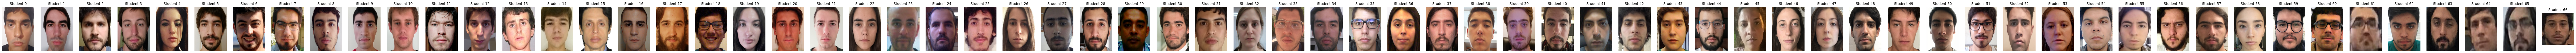

In [ ]:
number_of_students = len(os.listdir(ENROLL_IMGS_PATH))
filenames = [ENROLL_IMGS_PATH+x for x in os.listdir(ENROLL_IMGS_PATH)]
filenames.sort()
fig,ax = plt.subplots(1,number_of_students, figsize=(160, 10))
for i in range(number_of_students):
    with open(filenames[i],'rb') as f:
        image=Image.open(f)
        ax[i].imshow(image)
        ax[i].axis('off')
        ax[i].set_title(f"Student {i}")
fig.show()